In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
bist_daily = pd.read_csv("datasets/bist_100_daily.csv")

In [5]:
bist_daily

,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 11, 2019","1,079.22","1,080.31","1,082.18","1,074.65",1.62B,-0.08%
1,"Dec 10, 2019","1,080.11","1,089.12","1,093.78","1,076.18",2.07B,-0.71%
2,"Dec 09, 2019","1,087.86","1,088.96","1,091.25","1,081.39",2.32B,-0.08%
3,"Dec 06, 2019","1,088.69","1,090.09","1,093.15","1,083.52",2.16B,0.19%
4,"Dec 05, 2019","1,086.59","1,082.60","1,090.32","1,081.51",2.24B,0.89%
...,...,...,...,...,...,...,...
4995,"Jan 11, 2000",163.47,158.37,163.88,152.93,53.62M,3.22%
4996,"Jan 07, 2000",158.37,162.00,163.06,156.24,25.44M,-2.24%
4997,"Jan 06, 2000",162.00,169.32,174.61,160.87,66.09M,-4.32%
4998,"Jan 05, 2000",169.32,175.12,178.02,162.38,66.72M,-3.31%


In [19]:
bist_daily["Price"] = bist_daily["Price"].str.replace(',', '')
bist_daily["Price"] = pd.to_numeric(bist_daily["Price"])

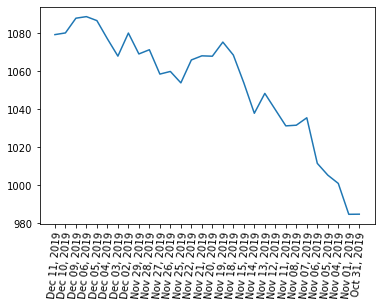

In [25]:
bist_sub = bist_daily.iloc[:30]
plt.plot(bist_sub["Date"], bist_sub["Price"])
plt.xticks(rotation = 85)
plt.show()